load 
num_ingr =  1989
==> Ingr embed layer Embedding(35549, 300, padding_idx=0)
torch.Size([1, 128])
torch.Size([1, 384])
Generating fake imgs...


/tmp/ipykernel_4171178/3686004675.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ins_feat= torch.tensor(ins_features).cuda()


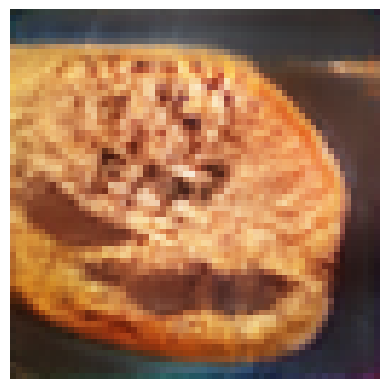

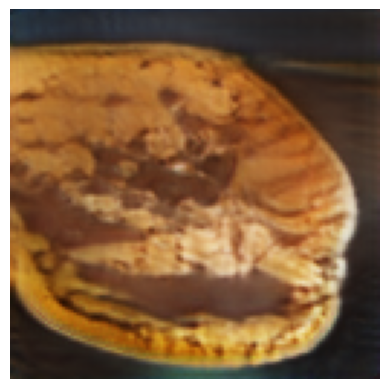

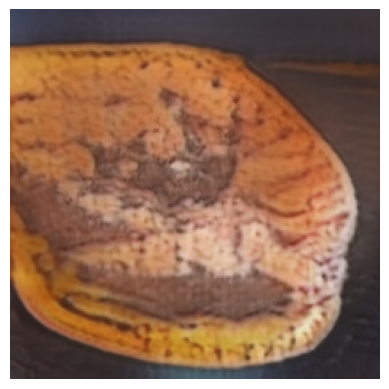

In [14]:
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from torchvision import transforms
import pickle
import numpy as np
import os
import json
from gensim.models.keyedvectors import KeyedVectors
from PIL import Image
import sys
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel
from get_wordvec import load_recipes, get_title_wordvec, get_ingredients_wordvec, get_instructions_wordvec
from model import G_NET
from text_encoder import TextEncoder
import matplotlib.pyplot as plt
import text_encoder
from miscc.config import cfg
from torch.autograd import Variable

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.orthogonal_(m.weight.data, 1.0)  # 直交
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)  # torch.nn.init.normal_(tensor, mean=0.0, std=1.0)
        # はテンソルを平均 mean、分散 std**2 の正規分布で初期化

        m.bias.data.fill_(0.0)
    elif classname.find('Linear') != -1:
        nn.init.orthogonal_(m.weight.data, 1.0)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

def build_models(netG_path):
        netG = G_NET()
        netG.eval()
        netG.apply(weights_init)
        netG = torch.nn.DataParallel(netG)
        # print(netG)
        
        state_dict = torch.load(netG_path)
        netG.load_state_dict(state_dict)
        print('load', cfg.TRAIN.NET_G)


        text_encoder = TextEncoder(
            data_dir='',
            emb_dim=300,
            hid_dim=100,
            z_dim=128,  # 1024
            # word2vec_file=ckpt_args.word2vec_file,
            with_attention=True,
            ingr_enc_type='fc'
        )
        text_encoder.eval()


        if cfg.CUDA:
            netG.cuda()

        return netG, text_encoder


def get_embedding(text, tokenizer, text_encoder):
    token = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = text_encoder(**token)
    features = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_size768)
    return features
    
word2vec_file='word2vec_recipes.bin'
vocab_ingrs_file='list_of_merged_ingredients.txt'

wv = KeyedVectors.load(word2vec_file, mmap='r')
# 从 word2vec_file 文件中加载预训练的 word2vec 向量
# mmap='r' 是一个内存映射选项，允许对存储在磁盘上的大文件进行部分读取，而不是一次性加载整个文件。这提高访问速度。
w2i = {w: i + 2 for i, w in enumerate(wv.index_to_key)}
w2i['<other>'] = 1
w2i = w2i

with open(vocab_ingrs_file, 'r') as f:
    vocab_ingrs = f.read().strip().split('\n')
    ingr2i = {ingr: i for i, ingr in enumerate(vocab_ingrs)}
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ins_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
# 创建一个线性层
linear_ing = nn.Linear(768, 128)
linear_ins = nn.Linear(768, 384)
    
netG_path = 'models/netG_360_cake_5000.pth'

netG, text_encoder = build_models(netG_path)


# Prepare your recipe
recipe = {'title': "Mummy Cupcakes", 
          'ingredients':["cake_mix",
          "Oreo_cookies",
          "pudding_mix",
          "milk",
          "powdered_sugar",
          "Cool_Whip",
          "chocolate_chips"],
          'instructions': [
          "Heat oven to 350F .",
          "Prepare cake batter as directed on package ; stir in cookies .",
          "Spoon into 24 paper-lined muffin cups .",
          "Bake 20 to 25 min .",
          "or until toothpick inserted in centres comes out clean .",
          "Cool cupcakes in pans 10 min .",
          "; remove to wire racks .",          
          "Beat pudding_mix , milk and sugar in large bowl whisk 2 min . , stir in Cool_Whip .",
          "Spoon into pastry bag fitted with basket-weave tip .",
          "Pipe pudding_mixture onto tops of cupcakes .",
          "Add chocolate_chips for the eyes .",
          "Keep refrigerated ."]
         }

instructions = recipe['instructions']
if len(instructions) > 0:
    instructions = ' '.join(instructions)
title, n_words_in_title = get_title_wordvec(recipe, w2i)  # np.int [max_len]  text to index
ingredients, n_ingrs = get_ingredients_wordvec(recipe, w2i, ingr2i)  # np.int [max_len]
title= torch.tensor(title).cuda()
title = title.unsqueeze(0)
ing = torch.tensor(ingredients).cuda()
ing = ing.unsqueeze(0)
nz = cfg.GAN.Z_DIM
noise = Variable(torch.FloatTensor(1, nz))
with torch.no_grad():
    ins_features = get_embedding(instructions, tokenizer, ins_encoder)
    ins_features = linear_ins(ins_features)
    ins_feat= torch.tensor(ins_features).cuda()

    txt_feat = text_encoder([title, ing])
    print(txt_feat.shape)
    print(ins_feat.shape)
    txt_embedding = torch.cat([txt_feat, ins_feat], dim=1)

    print("Generating fake imgs...")
    noise.data.normal_(0, 1)
    fake_imgs, _, _ = netG(noise, txt_embedding)


def show_images(images, num_images=1):
    for index in range(num_images):
        image = images[index].cpu().detach().numpy()

        image = np.transpose(image[0], (1, 2, 0))  # CxHxW => HxWxC
        image = (image + 1) / 2.0  # [-1, 1] => [0, 1]
        
        plt.imshow(image)
        plt.axis('off')
        plt.show()

# 64, 128, 256
show_images(fake_imgs, num_images=3)


In [16]:
!ls ../output/256_salad_10000_80_0/Model

netD0.pth  netD2.pth	netG_20.pth  netG_40.pth  netG_60.pth  netG_80.pth
netD1.pth  netG_10.pth	netG_30.pth  netG_50.pth  netG_70.pth  netG_90.pth


In [1]:
!python main.py

/home/users/std/2019/19k1109/anaconda3/envs/gan38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/users/std/2019/19k1109/anaconda3/envs/gan38/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
CUDA使用可能
Using config:
{'CONFIG_NAME': '',
 'CUDA': False,
 'DATASET_NAME': 'Recipe1M',
 'DATA_DIR': '/home/users/std/2019/19k1109/FoodGAN/data/Recipe1M',
 'EMBEDDING_TYPE': 'cnn-rnn',
 'GAN': {'B_CONDITION': True,
         'CONDITION_DIM': 128,
         'DF_DIM': 64,
         'EMBEDDING_DIM': 128,
         'GF_DIM': 64,
         'NETWORK_TYPE': 'default',
         'R_NUM'